In [ ]:
# Install the required package (if not already installed)
!pip install gdown


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('train-balanced-sarcasm.csv')

# Display the first few rows of the dataset
print(data.head())


   label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  


In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
!pip install gensim


In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())

# Check if cuDNN is installed
import os
cudnn_path = "/usr/local/cuda/lib64"
if os.path.exists(cudnn_path):
    print(f"cuDNN found at: {cudnn_path}")
else:
    print("cuDNN not found.")


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, BertModel
import torch

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pate2530/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/pate2530/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
train_df = data.copy()

In [6]:
train_df.dropna(axis=0,subset=['comment'],inplace=True)

In [7]:
train_df[train_df.isnull().any(axis=1)]['comment']

Series([], Name: comment, dtype: object)

In [8]:
train_df = train_df.iloc[:100000]

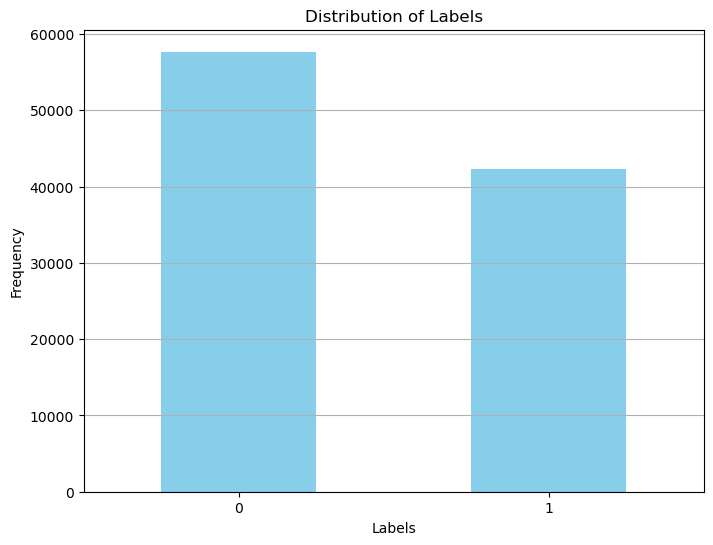

In [9]:
plt.figure(figsize=(8, 6))
train_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.show()

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(row):
    row = row.lower()
    row = re.sub(r'[^\w\s]', '', row)
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'



In [11]:
x_preprocessed = [preprocess(row) for row in train_df['comment']]

In [12]:

cache_dir = '/scratch/gilbreth/pate2530'
train_x, eval_x, train_y, eval_y=train_test_split(x_preprocessed,train_df['label'],test_size=0.3,train_size=0.7)

In [13]:
train_data = {'text': train_x, 'labels': train_y}
train_dataset = Dataset.from_dict(train_data)

eval_data = {'text': eval_x, 'labels': eval_y}
eval_dataset = Dataset.from_dict(eval_data)

In [14]:

# Define the model name
model_name = "bert-base-uncased"

# Load the tokenizer and model using Auto classes
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, cache_dir=cache_dir)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Tokenize the train and eval datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [ ]:
pip install --upgrade accelerate --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org


In [ ]:
pip install --upgrade pip


In [ ]:
pip install transformers[torch]


In [16]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
pip install --upgrade transformers accelerate


In [17]:
from transformers import EarlyStoppingCallback

# Define the compute_metrics function
def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(axis=-1)  # Convert logits to predicted class labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
# Define training arguments with logging and evaluation strategy
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # set to 'steps'
    logging_dir="./logs",  # Directory to store logs
    logging_steps=500,  # Log every 100 steps
    save_strategy="epoch",  # Save checkpoint every 'steps'
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01, # This will allow me to visualize the metrics with TensorBoard
    load_best_model_at_end=True, # Load best model after training
    metric_for_best_model="eval_loss",  # Metric to monitor
    greater_is_better=False,      # Lower eval_loss is better
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,  
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/home/pate2530/.conda/envs/cent7/2024.02-py311/drashti_patel/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_118502/1133389856.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
pip install wandb


In [19]:
# Train the model
trainer.train()

--- Logging error ---
Traceback (most recent call last):
  File "/home/pate2530/.conda/envs/cent7/2024.02-py311/drashti_patel/lib/python3.11/logging/__init__.py", line 1114, in emit
    self.flush()
  File "/home/pate2530/.conda/envs/cent7/2024.02-py311/drashti_patel/lib/python3.11/logging/__init__.py", line 1094, in flush
    self.stream.flush()
OSError: [Errno 122] Disk quota exceeded
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/pate2530/.conda/envs/cent7/2024.02-py311/drashti_patel/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/pate2530/.conda/envs/cent7/2024.02-py311/drashti_patel/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/home/pate2530/.conda/envs/cent7/2024.02-py311/drashti_patel/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.552800,0.631172,0.685467,0.676373,0.507016,0.579576
2,0.562900,0.650470,0.661267,0.609640,0.577799,0.593292
3,0.524900,0.641789,0.676800,0.693190,0.438026,0.536830


TrainOutput(global_step=13125, training_loss=0.5471955543154762, metrics={'train_runtime': 2493.7281, 'train_samples_per_second': 168.423, 'train_steps_per_second': 10.526, 'total_flos': 3.192453056878272e+16, 'train_loss': 0.5471955543154762, 'epoch': 3.0})

In [20]:

# Get predictions and true labels from the eval dataset
predictions = trainer.predict(eval_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

In [21]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
tn, fp, fn, tp = conf_matrix.ravel()
print(tn, fp, fn, tp)

Accuracy: 0.6854666666666667
Precision: 0.6763727121464226
Recall: 0.5070159027128157
F1 Score: 0.5795758331848155
Confusion Matrix:
[[14060  3112]
 [ 6324  6504]]
14060 3112 6324 6504


In [ ]:
# Saving the model
trainer.save_model("./saved_model")

# Saving the tokenizer
tokenizer.save_pretrained("./saved_model")

